In [92]:
# Import necessary libraries
import os
os.chdir("C:/Users/Pauli/OneDrive/Dokumente/Uni/Masterarbeit/code/preprocessing")
import pandas as pd
import numpy as np
import pickle
#nn modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

#metrics and plotting
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#other
from datasplit import get_datasplit
from featurescaling import scale_features
from earlystopper import EarlyStopper
import copy


In [93]:
#load necessary data
#open multi index pickle file
with open("data_split_multiind.pkl", "rb") as f:
    [ind_train, ind_val, ind_test, ind_holdout] = pickle.load(f)

#Load Kinase-ligand-K_off dataset
df_target_value = pd.read_excel("kinase_ligand_k_off.xlsx", sheet_name='kinase_ligand_k_off')
df_target_value = df_target_value.dropna(subset=["log_koff"])  #drop rows with missing target value

#choose if full or pocket kinase sequences
feature_set_kinase = "Pocket_Sequences_propy"   # "Sequences_propy" or "Pocket_Sequences_propy"
feature_set_ligand = "Mordred_Features"  # "Mordred_Features" or "Morgan_Fingerprints"

#prepare feature dataframe
    
df_ligand = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Ligand_"+feature_set_ligand)
df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_"+feature_set_kinase)

    
#merge dataframes
df = pd.merge(df_target_value, df_ligand, on="ligand", how="left") 
df_all = pd.merge(df, df_kinase, on="kinase", how="left")
df_all.dropna(subset=["log_koff"], inplace=True)  #drop rows with missing target value

#get iris split from my cleaned data set
df_train = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_train)].copy()
df_val = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_val)].copy()
df_test = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_test)].copy()
df_holdout = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_holdout)].copy()
#merge train and val for final training
df_train = pd.merge(df_train, df_val, how="outer")

In [94]:
ligand_selectors = {
    "Mordred_Features":      lambda df: df.loc[:, "ABC":"mZagreb2"],
    "Morgan_Fingerprints":   lambda df: df.loc[:, "morgan__0":"morgan__2047"],
    None:                    lambda df: df.iloc[:, 0:0],  # empty
}

kinase_selectors = {
    "ascii":                     lambda df: df.loc[:, "0":"84"],          # columns named "0".."84"
    "Sequences_propy":           lambda df: df.loc[:, "AAC":"APAAC"],
    "Pocket_Sequences_propy":    lambda df: df.loc[:, "AAC":"APAAC"],
    None:                        lambda df: df.iloc[:, 0:0],  # empty
}

In [95]:
ligand_cols = ligand_selectors[feature_set_ligand](df_train).columns.tolist()
kinase_cols = kinase_selectors[feature_set_kinase](df_train).columns.tolist()

#set feature_range for scalers if mordred
if feature_set_ligand == "Mordred_Features":
    feature_range = (-1, 1)
else:
    feature_range = (0, 1)


Iteration through all of the Features

In [96]:
#feature columns
extra_features = ["AAC", "DPC", "TPC", "MBauto", "Moranauto",
                  "Gearyauto", "CTD", "SOCN", "QSO", "PAAC", "APAAC"]

#scalar fitting for target value
y_raw = df_train["log_koff"].values.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaler.fit(y_raw)


MinMaxScaler()

In [97]:
import ast
def parse_list_cell(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)   # safe parsing of stringified list
        except Exception:
            return np.nan
    return x  # already a list/sequence

#df_train["AAC"] = df_train["AAC"].apply(parse_list_cell)


Using feature: AAC
Epoch 1/100, Train Loss: 0.0384, Val Loss: 0.0222
Epoch 2/100, Train Loss: 0.0235, Val Loss: 0.0244
Epoch 3/100, Train Loss: 0.0256, Val Loss: 0.0587
Epoch 4/100, Train Loss: 0.0236, Val Loss: 0.0284
Epoch 5/100, Train Loss: 0.0204, Val Loss: 0.0300
Epoch 6/100, Train Loss: 0.0203, Val Loss: 0.0419
Epoch 7/100, Train Loss: 0.0197, Val Loss: 0.0270
Epoch 8/100, Train Loss: 0.0194, Val Loss: 0.0258
Epoch 9/100, Train Loss: 0.0187, Val Loss: 0.0280
Epoch 10/100, Train Loss: 0.0189, Val Loss: 0.0348
Epoch 11/100, Train Loss: 0.0189, Val Loss: 0.0378
Epoch 12/100, Train Loss: 0.0191, Val Loss: 0.0296
Epoch 13/100, Train Loss: 0.0183, Val Loss: 0.0367
Epoch 14/100, Train Loss: 0.0177, Val Loss: 0.0288
Epoch 15/100, Train Loss: 0.0178, Val Loss: 0.0322
Epoch 16/100, Train Loss: 0.0181, Val Loss: 0.0448
Epoch 17/100, Train Loss: 0.0188, Val Loss: 0.0442
Epoch 18/100, Train Loss: 0.0174, Val Loss: 0.0344
Epoch 19/100, Train Loss: 0.0182, Val Loss: 0.0381
Epoch 20/100, Train L

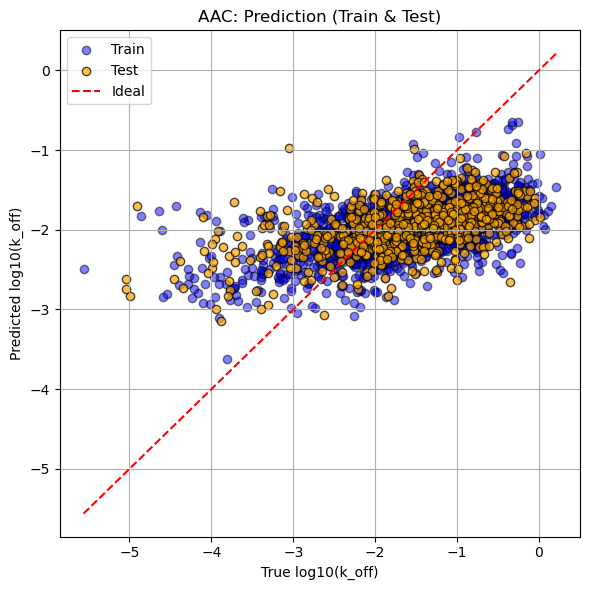

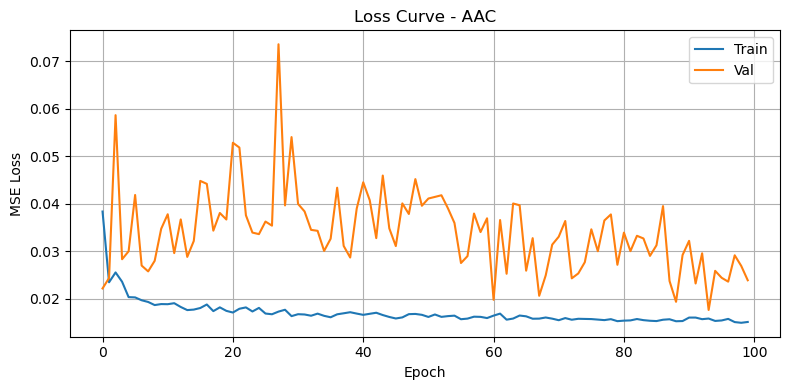

Using feature: DPC
Epoch 1/100, Train Loss: 0.0482, Val Loss: 0.0182
Epoch 2/100, Train Loss: 0.0203, Val Loss: 0.0384
Epoch 3/100, Train Loss: 0.0190, Val Loss: 0.0267
Epoch 4/100, Train Loss: 0.0226, Val Loss: 0.0388
Epoch 5/100, Train Loss: 0.0171, Val Loss: 0.0616
Epoch 6/100, Train Loss: 0.0172, Val Loss: 0.0379
Epoch 7/100, Train Loss: 0.0163, Val Loss: 0.0395
Epoch 8/100, Train Loss: 0.0168, Val Loss: 0.0312
Epoch 9/100, Train Loss: 0.0160, Val Loss: 0.0325
Epoch 10/100, Train Loss: 0.0156, Val Loss: 0.0640
Epoch 11/100, Train Loss: 0.0157, Val Loss: 0.0587
Epoch 12/100, Train Loss: 0.0145, Val Loss: 0.0385
Epoch 13/100, Train Loss: 0.0152, Val Loss: 0.0706
Epoch 14/100, Train Loss: 0.0149, Val Loss: 0.0516
Epoch 15/100, Train Loss: 0.0140, Val Loss: 0.0452
Epoch 16/100, Train Loss: 0.0144, Val Loss: 0.0565
Epoch 17/100, Train Loss: 0.0139, Val Loss: 0.0573
Epoch 18/100, Train Loss: 0.0151, Val Loss: 0.0396
Epoch 19/100, Train Loss: 0.0143, Val Loss: 0.0412
Epoch 20/100, Train L

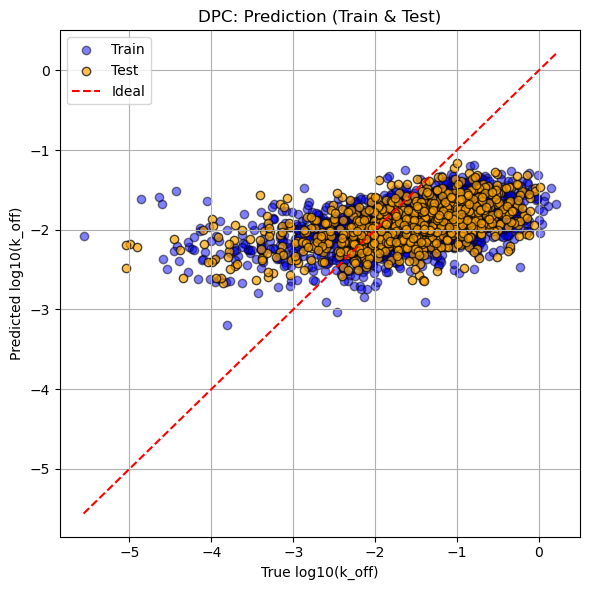

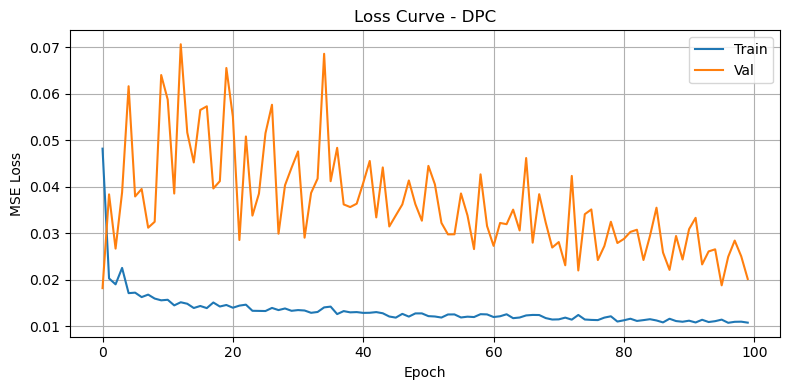

Using feature: TPC
Epoch 1/100, Train Loss: 1.5846, Val Loss: 0.1019
Epoch 2/100, Train Loss: 0.0677, Val Loss: 0.0766
Epoch 3/100, Train Loss: 0.0416, Val Loss: 0.0826
Epoch 4/100, Train Loss: 0.0336, Val Loss: 0.0552
Epoch 5/100, Train Loss: 0.0309, Val Loss: 0.0332
Epoch 6/100, Train Loss: 0.0285, Val Loss: 0.0421
Epoch 7/100, Train Loss: 0.0254, Val Loss: 0.0541
Epoch 8/100, Train Loss: 0.0251, Val Loss: 0.0387
Epoch 9/100, Train Loss: 0.0228, Val Loss: 0.0361
Epoch 10/100, Train Loss: 0.0230, Val Loss: 0.0406
Epoch 11/100, Train Loss: 0.0217, Val Loss: 0.0400
Epoch 12/100, Train Loss: 0.0199, Val Loss: 0.0382
Epoch 13/100, Train Loss: 0.0192, Val Loss: 0.0496
Epoch 14/100, Train Loss: 0.0188, Val Loss: 0.0364
Epoch 15/100, Train Loss: 0.0195, Val Loss: 0.0462
Epoch 16/100, Train Loss: 0.0181, Val Loss: 0.0604
Epoch 17/100, Train Loss: 0.0171, Val Loss: 0.0406
Epoch 18/100, Train Loss: 0.0170, Val Loss: 0.0536
Epoch 19/100, Train Loss: 0.0165, Val Loss: 0.0655
Epoch 20/100, Train L

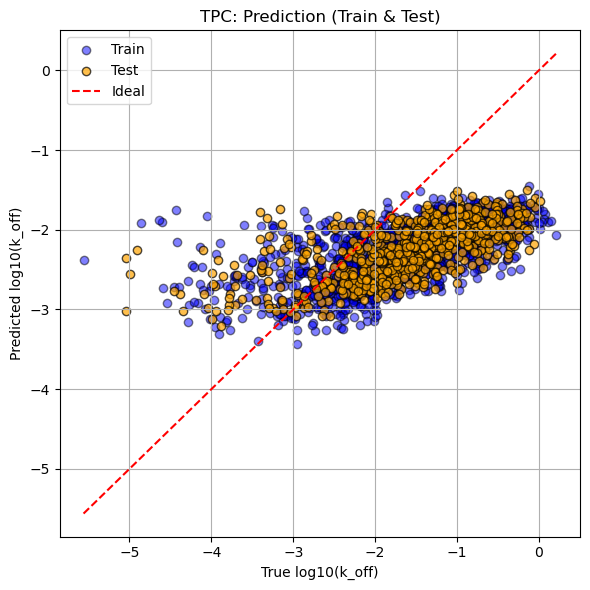

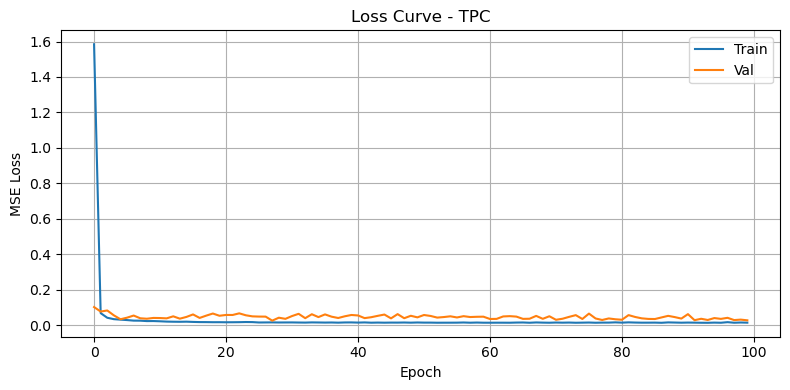

Using feature: MBauto
Epoch 1/100, Train Loss: 0.0498, Val Loss: 0.0293
Epoch 2/100, Train Loss: 0.0253, Val Loss: 0.0465
Epoch 3/100, Train Loss: 0.0233, Val Loss: 0.0665
Epoch 4/100, Train Loss: 0.0217, Val Loss: 0.0418
Epoch 5/100, Train Loss: 0.0203, Val Loss: 0.0558
Epoch 6/100, Train Loss: 0.0204, Val Loss: 0.0495
Epoch 7/100, Train Loss: 0.0207, Val Loss: 0.0772
Epoch 8/100, Train Loss: 0.0188, Val Loss: 0.0647
Epoch 9/100, Train Loss: 0.0175, Val Loss: 0.0572
Epoch 10/100, Train Loss: 0.0181, Val Loss: 0.0618
Epoch 11/100, Train Loss: 0.0175, Val Loss: 0.0463
Epoch 12/100, Train Loss: 0.0177, Val Loss: 0.0776
Epoch 13/100, Train Loss: 0.0176, Val Loss: 0.0613
Epoch 14/100, Train Loss: 0.0172, Val Loss: 0.0344
Epoch 15/100, Train Loss: 0.0164, Val Loss: 0.0478
Epoch 16/100, Train Loss: 0.0159, Val Loss: 0.0719
Epoch 17/100, Train Loss: 0.0174, Val Loss: 0.0512
Epoch 18/100, Train Loss: 0.0167, Val Loss: 0.0423
Epoch 19/100, Train Loss: 0.0167, Val Loss: 0.0667
Epoch 20/100, Trai

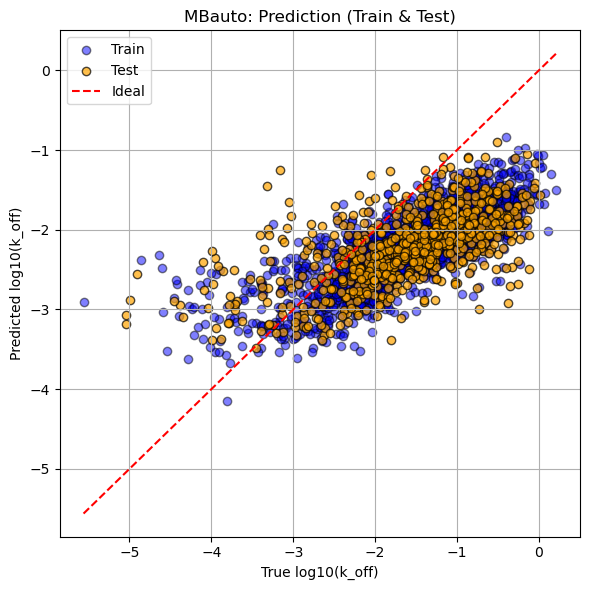

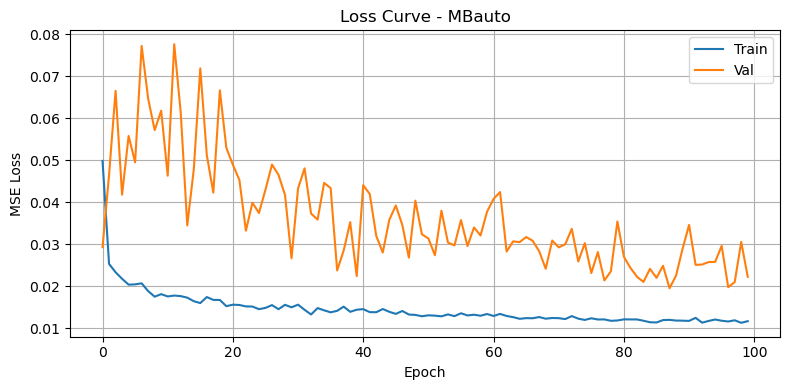

Using feature: Moranauto
Epoch 1/100, Train Loss: 0.0407, Val Loss: 0.0288
Epoch 2/100, Train Loss: 0.0190, Val Loss: 0.0364
Epoch 3/100, Train Loss: 0.0187, Val Loss: 0.0502
Epoch 4/100, Train Loss: 0.0171, Val Loss: 0.0279
Epoch 5/100, Train Loss: 0.0164, Val Loss: 0.0345
Epoch 6/100, Train Loss: 0.0161, Val Loss: 0.0382
Epoch 7/100, Train Loss: 0.0157, Val Loss: 0.0445
Epoch 8/100, Train Loss: 0.0142, Val Loss: 0.0370
Epoch 9/100, Train Loss: 0.0149, Val Loss: 0.0358
Epoch 10/100, Train Loss: 0.0140, Val Loss: 0.0480
Epoch 11/100, Train Loss: 0.0147, Val Loss: 0.0613
Epoch 12/100, Train Loss: 0.0143, Val Loss: 0.0362
Epoch 13/100, Train Loss: 0.0147, Val Loss: 0.0212
Epoch 14/100, Train Loss: 0.0148, Val Loss: 0.0358
Epoch 15/100, Train Loss: 0.0138, Val Loss: 0.0443
Epoch 16/100, Train Loss: 0.0134, Val Loss: 0.0281
Epoch 17/100, Train Loss: 0.0127, Val Loss: 0.0380
Epoch 18/100, Train Loss: 0.0131, Val Loss: 0.0398
Epoch 19/100, Train Loss: 0.0128, Val Loss: 0.0380
Epoch 20/100, T

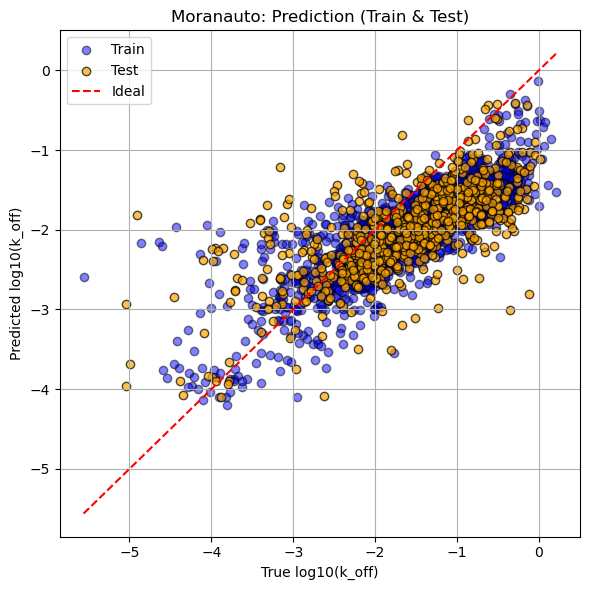

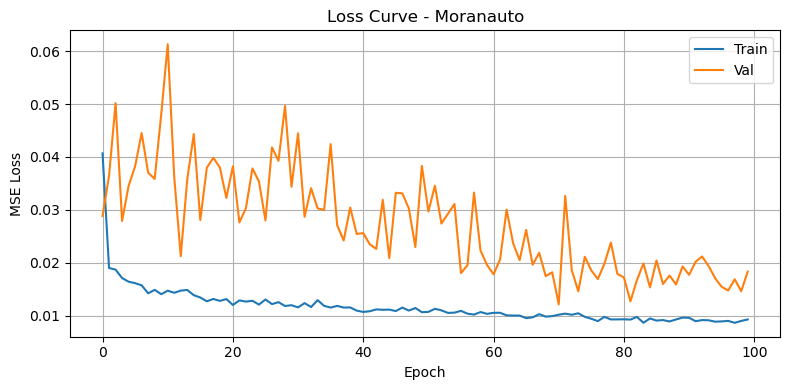

Using feature: Gearyauto
Epoch 1/100, Train Loss: 0.0405, Val Loss: 0.0301
Epoch 2/100, Train Loss: 0.0198, Val Loss: 0.0134
Epoch 3/100, Train Loss: 0.0178, Val Loss: 0.0330
Epoch 4/100, Train Loss: 0.0172, Val Loss: 0.0259
Epoch 5/100, Train Loss: 0.0182, Val Loss: 0.0497
Epoch 6/100, Train Loss: 0.0162, Val Loss: 0.0375
Epoch 7/100, Train Loss: 0.0156, Val Loss: 0.0253
Epoch 8/100, Train Loss: 0.0168, Val Loss: 0.0336
Epoch 9/100, Train Loss: 0.0156, Val Loss: 0.0326
Epoch 10/100, Train Loss: 0.0145, Val Loss: 0.0258
Epoch 11/100, Train Loss: 0.0152, Val Loss: 0.0347
Epoch 12/100, Train Loss: 0.0154, Val Loss: 0.0276
Epoch 13/100, Train Loss: 0.0144, Val Loss: 0.0631
Epoch 14/100, Train Loss: 0.0156, Val Loss: 0.0327
Epoch 15/100, Train Loss: 0.0143, Val Loss: 0.0456
Epoch 16/100, Train Loss: 0.0133, Val Loss: 0.0391
Epoch 17/100, Train Loss: 0.0138, Val Loss: 0.0430
Epoch 18/100, Train Loss: 0.0140, Val Loss: 0.0412
Epoch 19/100, Train Loss: 0.0133, Val Loss: 0.0426
Epoch 20/100, T

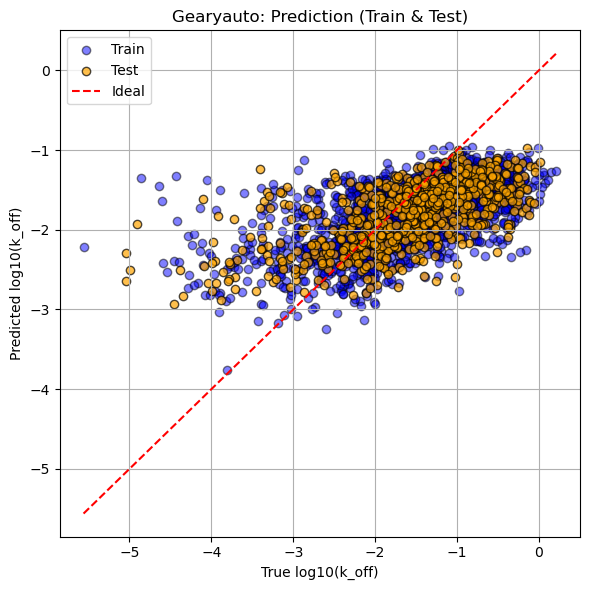

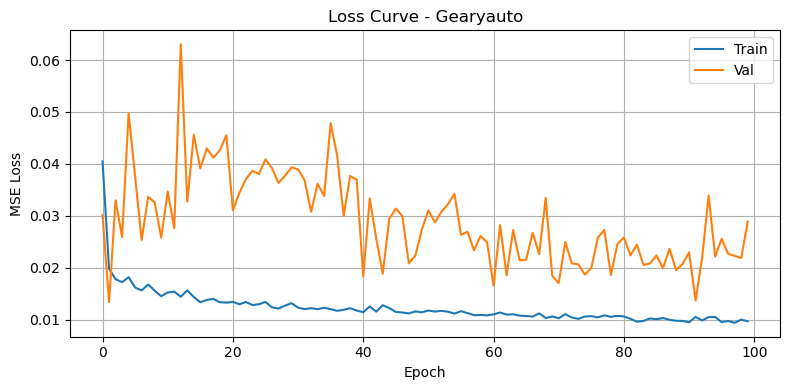

Using feature: CTD
Epoch 1/100, Train Loss: 0.0378, Val Loss: 0.0245
Epoch 2/100, Train Loss: 0.0217, Val Loss: 0.0212
Epoch 3/100, Train Loss: 0.0195, Val Loss: 0.0186
Epoch 4/100, Train Loss: 0.0185, Val Loss: 0.0289
Epoch 5/100, Train Loss: 0.0192, Val Loss: 0.0298
Epoch 6/100, Train Loss: 0.0172, Val Loss: 0.0335
Epoch 7/100, Train Loss: 0.0199, Val Loss: 0.0195
Epoch 8/100, Train Loss: 0.0173, Val Loss: 0.0335
Epoch 9/100, Train Loss: 0.0171, Val Loss: 0.0336
Epoch 10/100, Train Loss: 0.0168, Val Loss: 0.0346
Epoch 11/100, Train Loss: 0.0169, Val Loss: 0.0323
Epoch 12/100, Train Loss: 0.0164, Val Loss: 0.0340
Epoch 13/100, Train Loss: 0.0160, Val Loss: 0.0299
Epoch 14/100, Train Loss: 0.0157, Val Loss: 0.0328
Epoch 15/100, Train Loss: 0.0155, Val Loss: 0.0286
Epoch 16/100, Train Loss: 0.0155, Val Loss: 0.0260
Epoch 17/100, Train Loss: 0.0150, Val Loss: 0.0423
Epoch 18/100, Train Loss: 0.0148, Val Loss: 0.0338
Epoch 19/100, Train Loss: 0.0161, Val Loss: 0.0202
Epoch 20/100, Train L

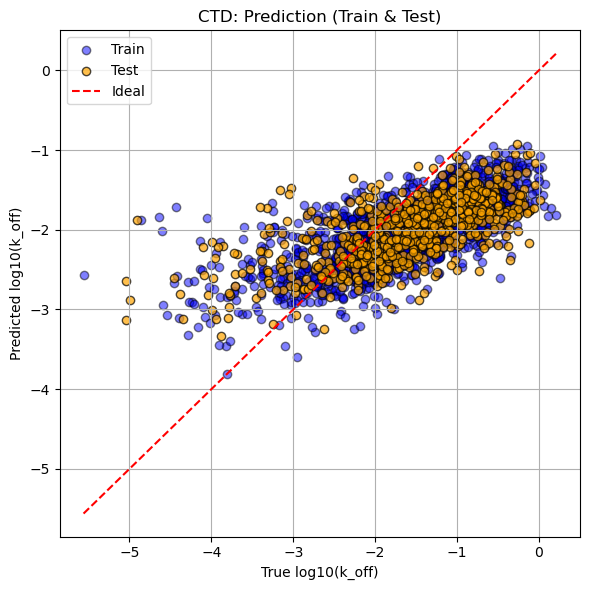

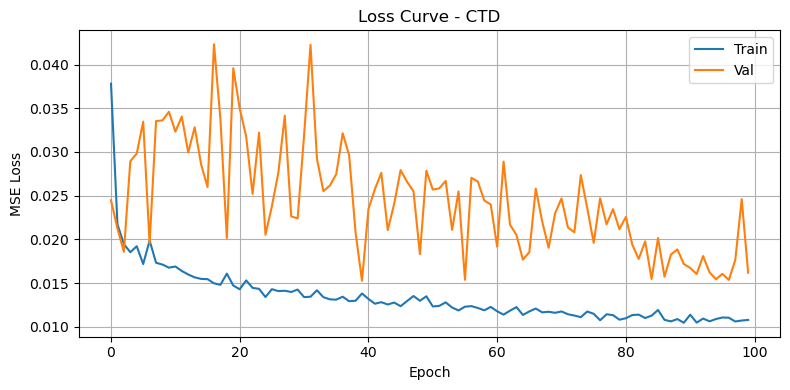

Using feature: SOCN
Epoch 1/100, Train Loss: 0.0394, Val Loss: 0.0224
Epoch 2/100, Train Loss: 0.0226, Val Loss: 0.0171
Epoch 3/100, Train Loss: 0.0224, Val Loss: 0.0232
Epoch 4/100, Train Loss: 0.0201, Val Loss: 0.0237
Epoch 5/100, Train Loss: 0.0201, Val Loss: 0.0257
Epoch 6/100, Train Loss: 0.0199, Val Loss: 0.0464
Epoch 7/100, Train Loss: 0.0188, Val Loss: 0.0296
Epoch 8/100, Train Loss: 0.0186, Val Loss: 0.0195
Epoch 9/100, Train Loss: 0.0173, Val Loss: 0.0371
Epoch 10/100, Train Loss: 0.0175, Val Loss: 0.0259
Epoch 11/100, Train Loss: 0.0176, Val Loss: 0.0364
Epoch 12/100, Train Loss: 0.0169, Val Loss: 0.0316
Epoch 13/100, Train Loss: 0.0171, Val Loss: 0.0338
Epoch 14/100, Train Loss: 0.0173, Val Loss: 0.0369
Epoch 15/100, Train Loss: 0.0170, Val Loss: 0.0550
Epoch 16/100, Train Loss: 0.0179, Val Loss: 0.0542
Epoch 17/100, Train Loss: 0.0177, Val Loss: 0.0455
Epoch 18/100, Train Loss: 0.0172, Val Loss: 0.0267
Epoch 19/100, Train Loss: 0.0166, Val Loss: 0.0361
Epoch 20/100, Train 

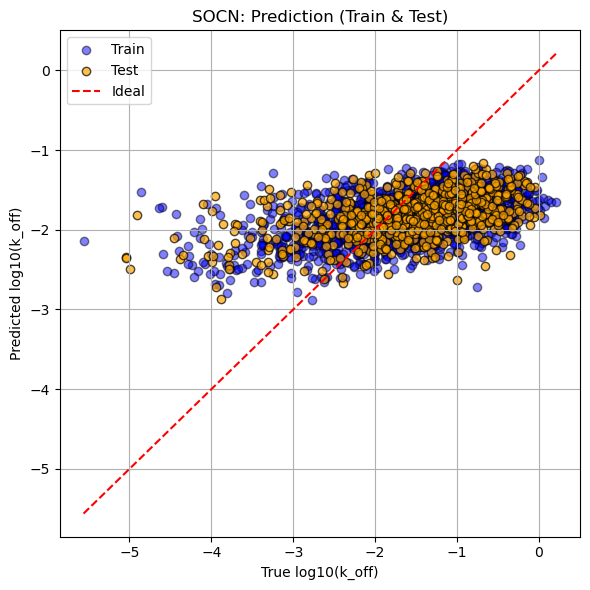

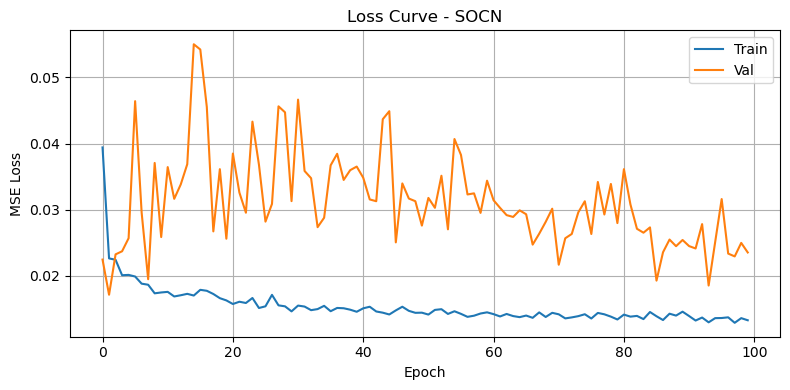

Using feature: QSO
Epoch 1/100, Train Loss: 0.0442, Val Loss: 0.0351
Epoch 2/100, Train Loss: 0.0218, Val Loss: 0.0432
Epoch 3/100, Train Loss: 0.0198, Val Loss: 0.0543
Epoch 4/100, Train Loss: 0.0201, Val Loss: 0.0431
Epoch 5/100, Train Loss: 0.0177, Val Loss: 0.0441
Epoch 6/100, Train Loss: 0.0172, Val Loss: 0.0535
Epoch 7/100, Train Loss: 0.0171, Val Loss: 0.0482
Epoch 8/100, Train Loss: 0.0184, Val Loss: 0.0479
Epoch 9/100, Train Loss: 0.0160, Val Loss: 0.0434
Epoch 10/100, Train Loss: 0.0172, Val Loss: 0.0244
Epoch 11/100, Train Loss: 0.0167, Val Loss: 0.0584
Epoch 12/100, Train Loss: 0.0164, Val Loss: 0.0547
Epoch 13/100, Train Loss: 0.0165, Val Loss: 0.0537
Epoch 14/100, Train Loss: 0.0162, Val Loss: 0.0458
Epoch 15/100, Train Loss: 0.0154, Val Loss: 0.0511
Epoch 16/100, Train Loss: 0.0156, Val Loss: 0.0559
Epoch 17/100, Train Loss: 0.0157, Val Loss: 0.0539
Epoch 18/100, Train Loss: 0.0155, Val Loss: 0.0537
Epoch 19/100, Train Loss: 0.0157, Val Loss: 0.0270
Epoch 20/100, Train L

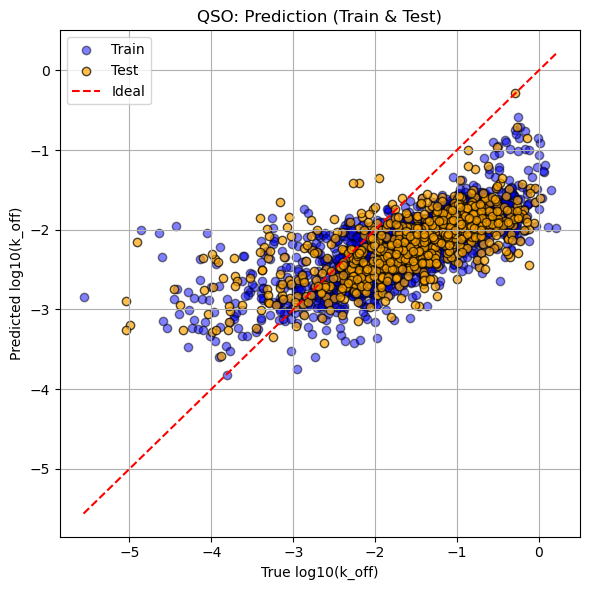

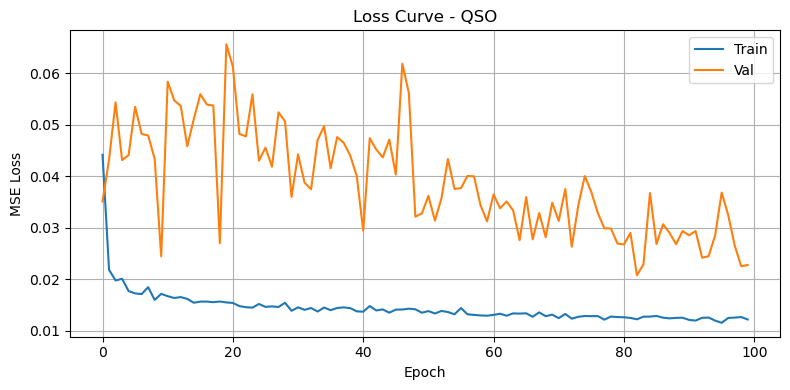

Using feature: PAAC
Epoch 1/100, Train Loss: 0.0392, Val Loss: 0.0289
Epoch 2/100, Train Loss: 0.0215, Val Loss: 0.0189
Epoch 3/100, Train Loss: 0.0215, Val Loss: 0.0169
Epoch 4/100, Train Loss: 0.0206, Val Loss: 0.0314
Epoch 5/100, Train Loss: 0.0195, Val Loss: 0.0250
Epoch 6/100, Train Loss: 0.0179, Val Loss: 0.0299
Epoch 7/100, Train Loss: 0.0175, Val Loss: 0.0303
Epoch 8/100, Train Loss: 0.0191, Val Loss: 0.0276
Epoch 9/100, Train Loss: 0.0170, Val Loss: 0.0342
Epoch 10/100, Train Loss: 0.0186, Val Loss: 0.0376
Epoch 11/100, Train Loss: 0.0170, Val Loss: 0.0296
Epoch 12/100, Train Loss: 0.0181, Val Loss: 0.0423
Epoch 13/100, Train Loss: 0.0177, Val Loss: 0.0210
Epoch 14/100, Train Loss: 0.0166, Val Loss: 0.0302
Epoch 15/100, Train Loss: 0.0161, Val Loss: 0.0191
Epoch 16/100, Train Loss: 0.0168, Val Loss: 0.0318
Epoch 17/100, Train Loss: 0.0160, Val Loss: 0.0281
Epoch 18/100, Train Loss: 0.0153, Val Loss: 0.0295
Epoch 19/100, Train Loss: 0.0161, Val Loss: 0.0328
Epoch 20/100, Train 

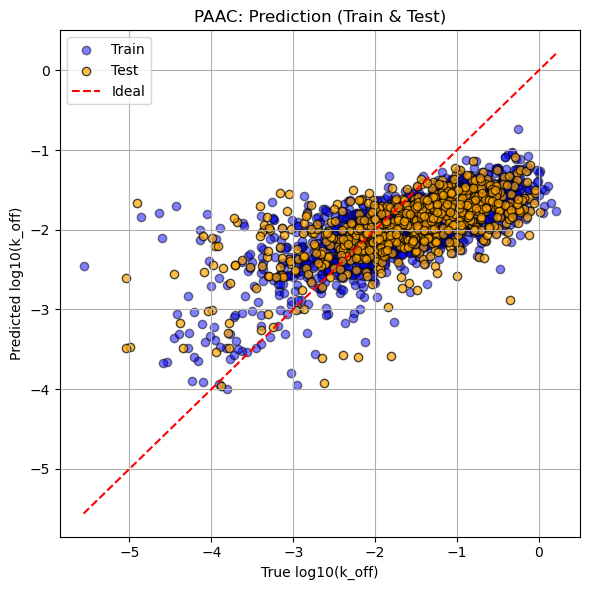

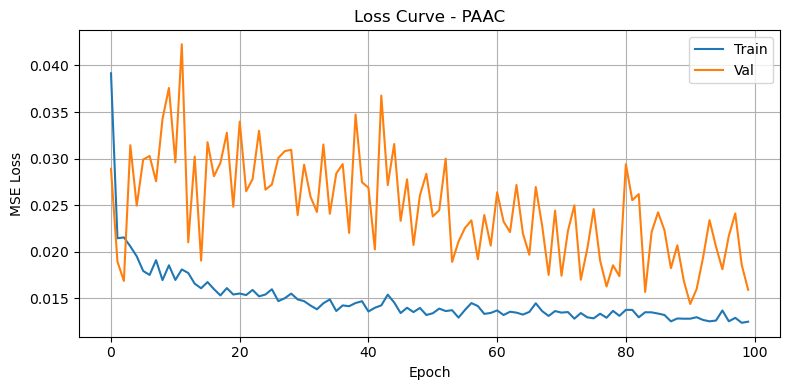

Using feature: APAAC
Epoch 1/100, Train Loss: 0.0435, Val Loss: 0.0303
Epoch 2/100, Train Loss: 0.0253, Val Loss: 0.0386
Epoch 3/100, Train Loss: 0.0236, Val Loss: 0.0239
Epoch 4/100, Train Loss: 0.0227, Val Loss: 0.0166
Epoch 5/100, Train Loss: 0.0234, Val Loss: 0.0251
Epoch 6/100, Train Loss: 0.0236, Val Loss: 0.0317
Epoch 7/100, Train Loss: 0.0220, Val Loss: 0.0311
Epoch 8/100, Train Loss: 0.0214, Val Loss: 0.0394
Epoch 9/100, Train Loss: 0.0212, Val Loss: 0.0262
Epoch 10/100, Train Loss: 0.0214, Val Loss: 0.0357
Epoch 11/100, Train Loss: 0.0206, Val Loss: 0.0482
Epoch 12/100, Train Loss: 0.0222, Val Loss: 0.0345
Epoch 13/100, Train Loss: 0.0213, Val Loss: 0.0422
Epoch 14/100, Train Loss: 0.0205, Val Loss: 0.0464
Epoch 15/100, Train Loss: 0.0196, Val Loss: 0.0440
Epoch 16/100, Train Loss: 0.0191, Val Loss: 0.0350
Epoch 17/100, Train Loss: 0.0203, Val Loss: 0.0531
Epoch 18/100, Train Loss: 0.0195, Val Loss: 0.0447
Epoch 19/100, Train Loss: 0.0200, Val Loss: 0.0492
Epoch 20/100, Train

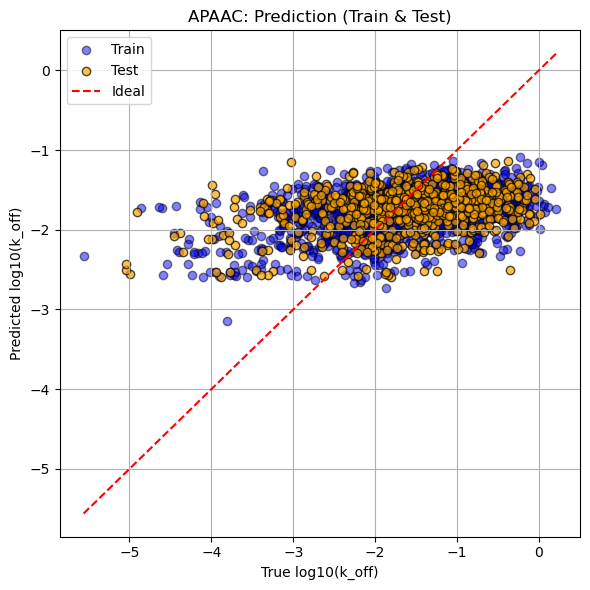

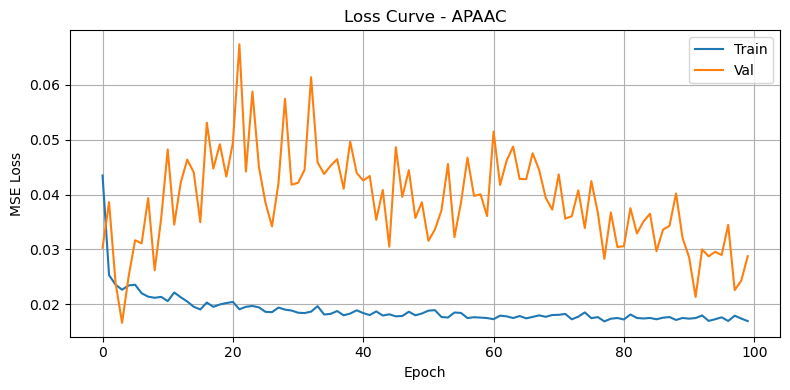

      Feature  Best Epoch  Train Loss  Validation Loss       MAE        R2
0         AAC          94    0.015160         0.017686  0.672974  0.094482
1         DPC           1    0.010806         0.018221  0.678331  0.082294
2         TPC          28    0.013869         0.025341  0.824752 -0.182595
3      MBauto          88    0.011630         0.019475  0.787063 -0.104446
4   Moranauto          71    0.009247         0.012103  0.602101  0.282062
5   Gearyauto           2    0.009662         0.013373  0.559095  0.318665
6         CTD          40    0.010788         0.015272  0.646865  0.197324
7        SOCN           2    0.013268         0.017128  0.646858  0.134357
8         QSO          83    0.012175         0.020764  0.766507 -0.037227
9        PAAC          91    0.012498         0.014398  0.623784  0.218201
10      APAAC           4    0.016950         0.016642  0.666179  0.077301


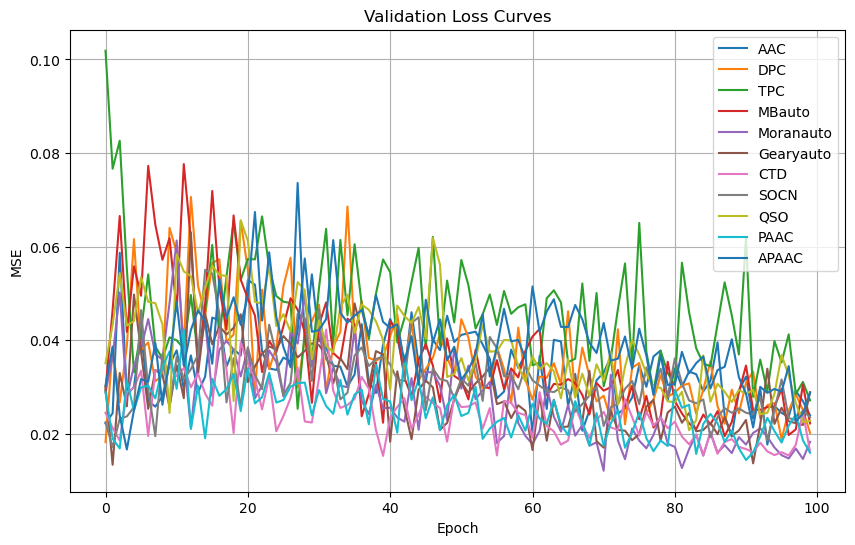

In [98]:
#model
dropout_ratio = 0.3

class NN_regression(nn.Module):
    def __init__(self, in_len, out_len=1, dropout_ratio=dropout_ratio):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1 = nn.Linear(in_len, 256)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, out_len)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.layer1(x))
        x = self.dropout2(x)
        x = F.relu(self.layer2(x))
        return self.output(x)

results = []
all_loss_curves = {}

for feature_name in extra_features:
    print(f"Using feature: {feature_name}")

    # Extract and scale only the protein features from the TRAIN dataframe!
    X_ligand_train = df_train[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
    X_kinase_train = df_train[feature_name].apply(parse_list_cell).tolist()
    x_scaler_ligand = MinMaxScaler(feature_range).fit(X_ligand_train)
    x_scaler_kinase = MinMaxScaler(feature_range).fit(X_kinase_train)

    

    def prepare_tensors(df, scaler_ligand, scaler_kinase):
        y = (df["log_koff"].values).reshape(-1, 1)
        y_scaled = y_scaler.transform(y)
        if feature_set_ligand=="Morgan_Fingerprints":
            X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
            X_kinase = df[feature_name].apply(parse_list_cell).tolist()
            X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
            X = np.hstack([X_scaled_kinase, X_ligand])
            print("Using unscaled Morgan Fingerprints for ligands.")
        else:
            X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
            X_kinase = df[feature_name].apply(parse_list_cell).tolist()
            X_scaled_ligand = x_scaler_ligand.transform(X_ligand)
            X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
            X =  np.hstack([X_scaled_kinase, X_scaled_ligand])
            
        X_tensor = torch.tensor(X, dtype=torch.float32) # Konvertieren in Tensoren
        y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
        return TensorDataset(X_tensor, y_tensor)




    train_ds = prepare_tensors(df_train, scaler_ligand=x_scaler_ligand, scaler_kinase=x_scaler_kinase)
    test_ds = prepare_tensors(df_test, scaler_ligand=x_scaler_ligand, scaler_kinase=x_scaler_kinase)
    val_ds = prepare_tensors(df_val,scaler_ligand=x_scaler_ligand, scaler_kinase=x_scaler_kinase)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
    model = NN_regression(in_len=train_ds.tensors[0].shape[1]) #model initializing!
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #adam optimizer, learning rate = 0.001
    loss_fn = nn.MSELoss() #loss function
    #early_stopper = EarlyStopper(patience=10, min_delta=0.0001) #standard min_delta is 0.001


    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_model_path = f"best_model_{feature_name}.pt"

    for epoch in range(100):  # n_epochs, so far 100 is the best
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad() #reset gradients
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in val_loader) / len(val_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}/100, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")
        
       # if early_stopper.early_stop(val_loss):
       #     print(f"EarlyStopper triggered at epoch {epoch+1}")
        #    break



    model.load_state_dict(torch.load(best_model_path)) #loading my best model



    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        # Test predictions
        y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
        y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
        y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

        # Train predictions
        y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
        y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())
        
        for xb, yb in test_loader: #final testing with test set 
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            test_loss += loss_fn(pred, yb).item()
    avg_test_loss = test_loss / len(test_loader)
    print(f"Final TEST loss: {avg_test_loss:.4f}")

    mae = mean_absolute_error(y_test_true, y_test_pred)
    r2 = r2_score(y_test_true, y_test_pred)

    results.append({
        "Feature": feature_name,
        "Best Epoch": np.argmin(val_losses) + 1,
        "Train Loss": train_losses[-1],
        "Validation Loss": min(val_losses),
        "MAE": mae,
        "R2": r2
    })
    all_loss_curves[feature_name] = {"train": train_losses, "val": val_losses}


#scatter plot of predicted vs true values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', c='blue', edgecolors='k')
    plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='orange', edgecolors='k')
    min_val = min(y_train_true.min(), y_test_true.min())
    max_val = max(y_train_true.max(), y_test_true.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    plt.xlabel("True log10(k_off)")
    plt.ylabel("Predicted log10(k_off)")
    plt.title(f"{feature_name}: Prediction (Train & Test)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#loss plot
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.title(f"Loss Curve - {feature_name}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    os.remove(best_model_path)  # cleanup

#table with the results
results_df = pd.DataFrame(results)
print(results_df)

#plotting all of the loss functions
plt.figure(figsize=(10, 6))
for feat, curves in all_loss_curves.items():
    plt.plot(curves["val"], label=f"{feat}")
plt.title("Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()
